# **Les aventuriers des Axes Perdus**
# Epoch 5-bis : 

***Olivier Thöni*** *(novice en IA, et sinon... professeur de mathématiques)*

*School of AI - Le Mans*

Lien vers le présent NoteBook : https://frama.link/OT_dimension5bis       


## **2.3. Auto-encoder Variationnel (VAE)**

source : https://www.kdnuggets.com/2018/11/variational-autoencoders-explained.html 

Dans cet exemple, nous allons nous pencher davantage sur l'***espace latent***, c'est-à-dire la zone où se situe le goulot d'étranglement.

Il y a deux gros problèmes avec l'approche de l'espace latent :

1. Quelle information contient chaque dimension? Certaines dimensions peuvent concerner des informations abstraites, par exemple le style. Même s'il était facile d'interpréter toutes les dimensions, nous ne voudrions pas attribuer d'étiquettes au jeu de données. Cette approche ne serait pas adaptée à de nouveaux ensembles de données.

2. L'espace latent peut être enchevêtré, c'est-à-dire que les dimensions peuvent être corrélées. Un chiffre dessiné très rapidement, par exemple, peut entraîner des coups de crayon inclinés et plus fins. Il est difficile de spécifier ces dépendances.

Le Deep Learning vient à la rescousse.



Le modèle présenté, à base de TensorFlow, sera également entraîné sur la base de données de chiffres manuscrits MNIST, voici son architecture :

![Variationnal AutoEncoder](https://drive.google.com/uc?id=1IEY7Mi9R1lkxhtdKPW_Fyrls_O-jhXmE)

Sur le côté gauche, nous avons la définition du modèle : une image d'entrée est transmise via un réseau de codeurs/décodeurs entre l'*input* et l'*output*.

Du côté droit, nous avons la perte : erreur de reconstruction : la sortie doit être similaire à l'entrée.

Afin de générer de nouvelles images, nous allons nous amuser à directement échantillonner un vecteur latent de la distribution précédente et le décoder en une image.

De plus, nous verrons comment utiliser une astuce pour conditionner le vecteur latent afin de pouvoir décider pour quel chiffre nous souhaitons générer une image.

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data')
input_size = 28 * 28
num_digits = 10

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as offi

Ensuite, nous allons définir les hyperparamètres que nous allons utiliser.

In [0]:
params = {
    'encoder_layers': [128],                # the encoder will be implemented using a simple feed forward network
    'decoder_layers': [128],                # and so will the decoder (CNN will be better, but we want to keep the code simple)
    'digit_classification_layers': [128],   # this is for the conditioning. 
    'activation': tf.nn.sigmoid,            # the activation function used by all sub-networks
    'decoder_std': 0.5,                     # the standard deviation of P(x|z) 
    'z_dim': 10,                            # the dimension of the latent space
    'digit_classification_weight': 10.0,    # this is for the conditioning.
    'epochs': 20,
    'batch_size': 100,
    'learning_rate': 0.001
}

Le modèle est composé de trois sous-réseaux :

* Étant donné x(image), la coder dans une distribution sur l'espace latent - appelé Q(z|x) 
* Étant donné z dans l'espace latent (représentation du code d'une image),décodez-le en l'image qu'elle représente - appelée f(z).
* Étant donné x, classifiez son chiffre en le mappant sur une couche de taille 10 où la n<sup>ème</sup> valeur contient la probabilité du n<sup>ème</sup> chiffre.

Les deux premiers sous-réseaux sont le cadre "**VAE nature**".

La troisième est utilisé comme tâche auxiliaire , qui appliquera certaines des dimensions latentes pour coder le chiffre trouvé dans une image. Voilà pourquoi : nous ne nous soucions pas des informations détenues par chaque dimension de l'espace latent. Le modèle peut apprendre à coder toutes les informations qu'il juge précieuses pour sa tâche. Étant donné que nous connaissons l'ensemble de données, nous savons que le type de chiffre doit être important. Nous voulons aider le modèle en lui fournissant ces informations. De plus, nous utiliserons ces informations pour générer des images conditionnées par le type de chiffre, comme expliqué plus tard.

Étant donné le type de chiffre, nous le coderons en utilisant un encodage à chaud, c'est-à-dire un vecteur de taille 10. Ces 10 nombres seront concaténés dans le vecteur latent, donc lors du décodage de ce vecteur dans une image, le modèle utilisera les informations numériques.

Il existe deux façons de fournir au modèle un seul vecteur d'encodage à chaud:
* L'ajouter comme entrée au modèle.
* L'ajouter comme étiquette pour que le modèle doive le prédire par lui-même: nous ajouterons un autre sous-réseau qui prédit un vecteur de taille 10 où la perte est l'entropie croisée (*cross-entropy*) avec le vecteur chaud attendu. C'est cette deuxième option que nous utiliserons, car cela peut se faire de deux manières :
    * Fournir une image en entrée et déduire un vecteur latent.
    * Fournir un vecteur latent en entrée et générer une image.
Comme nous voulons également prendre en charge la première option, nous ne pouvons pas fournir le modèle avec le chiffre en entrée, car nous ne le connaîtrons pas pendant la phase de test. Par conséquent, le modèle doit apprendre à le prédire.


Allons-y...



In [0]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)


def digit_classifier(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    logits = tf.layers.dense(x, num_digits)
    return logits

In [4]:
images = tf.placeholder(tf.float32, [None, input_size])
digits = tf.placeholder(tf.int32, [None])

# encode an image into a distribution over the latent space
encoder_mu, encoder_var = encoder(images,
                                  params['encoder_layers'])

# sample a latent vector from the latent space - using the reparameterization trick
eps = tf.random_normal(shape=[tf.shape(images)[0],
                              params['z_dim']],
                       mean=0.0,
                       stddev=1.0)
z = encoder_mu + tf.sqrt(encoder_var) * eps

# classify the digit
digit_logits = digit_classifier(images,
                                params['digit_classification_layers'])
digit_prob = tf.nn.softmax(digit_logits)

# decode the latent vector - concatenated to the digits classification - into an image
decoded_images = decoder(tf.concat([z, digit_prob], axis=1),
                         params['decoder_layers'])

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [5]:
# the loss is composed of how well we can reconstruct the image
loss_reconstruction = -tf.reduce_sum(
    tf.contrib.distributions.Normal(
        decoded_images,
        params['decoder_std']
    ).log_prob(images),
    axis=1
)

# and how off the distribution over the latent space is from the prior.
# Given the prior is a standard Gaussian and the inferred distribution
# is a Gaussian with a diagonal covariance matrix, the KL-divergence
# becomes analytically solvable, and we get
loss_prior = -0.5 * tf.reduce_sum(
    1 + tf.log(encoder_var) - encoder_mu ** 2 - encoder_var,
    axis=1
)

loss_auto_encode = tf.reduce_mean(
    loss_reconstruction + loss_prior,
    axis=0
)

# digit_classification_weight is used to weight between the two losses,
# since there's a tension between them
loss_digit_classifier = params['digit_classification_weight'] * tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=digits,
                                                   logits=digit_logits),
    axis=0
)

loss = loss_auto_encode + loss_digit_classifier

train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Entraînement**

Nous allons entraîner le modèle pour optimiser les deux pertes - la perte VAE et la perte de classification - en utilisant la **Descente de Gradient Stachastique** (SGD) .

À la fin de chaque époque, nous échantillonnerons des vecteurs latents et les décoderons en images, afin de pouvoir visualiser comment la puissance génératrice du modèle s'améliore au cours des époques. La méthode d'échantillonnage est la suivante :
* définir de manière déterministe les dimensions utilisées pour la classification des chiffres en fonction du chiffre pour lequel nous voulons générer une image. Si par exemple nous voulons générer une image du chiffre 2, ces dimensions seront réglées sur [0010000000].
Échantillonner au hasard les autres dimensions en fonction de l'*a priori* - une gaussienne multivariée. Nous utiliserons ces valeurs échantillonnées pour tous les différents chiffres que nous générons à une époque donnée. De cette façon, nous pouvons avoir une idée de ce qui est codé dans les autres dimensions, par exemple le style de trait.
L'intuition derrière l'étape 1 est qu'après la convergence, le modèle devrait être capable de classer le chiffre dans une image d'entrée en utilisant ces dimensions. D'autre part, ces dimensions sont également utilisées dans l'étape de décodage pour générer l'image. Cela signifie que le sous-réseau du décodeur apprend que lorsque ces dimensions ont les valeurs correspondant au chiffre 2, il doit générer une image de ce chiffre. Par conséquent, si nous définissons manuellement ces dimensions pour contenir les informations du chiffre 2, nous obtiendrons une image générée de ce chiffre.

In [0]:
samples = []
losses_auto_encode = []
losses_digit_classifier = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(params['epochs']):
        for _ in range(int(mnist.train.num_examples / params['batch_size'])):
            batch_images, batch_digits = mnist.train.next_batch(params['batch_size'])
            sess.run(train_op, feed_dict={images: batch_images, digits: batch_digits})
        
        train_loss_auto_encode, train_loss_digit_classifier = sess.run(
            [loss_auto_encode, loss_digit_classifier],
            {images: mnist.train.images, digits: mnist.train.labels})
        
        losses_auto_encode.append(train_loss_auto_encode)
        losses_digit_classifier.append(train_loss_digit_classifier)
        
        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[num_digits, 1])
        gen_samples = sess.run(decoded_images,
                               feed_dict={z: sample_z, digit_prob: np.eye(num_digits)})
        samples.append(gen_samples)

Vérifions que les deux pertes ont l'air bonnes, c'est-à-dire qu'elles diminuent :

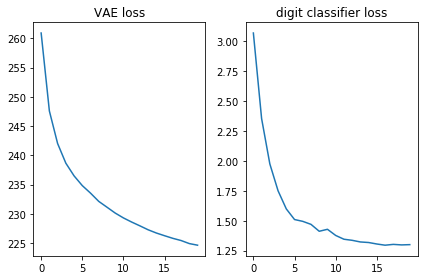

In [7]:
plt.subplot(121)
plt.plot(losses_auto_encode)
plt.title('VAE loss')

plt.subplot(122)
plt.plot(losses_digit_classifier)
plt.title('digit classifier loss')

plt.tight_layout()

De plus, traçons les images générées pour voir si le modèle a pu générer des images de chiffres :

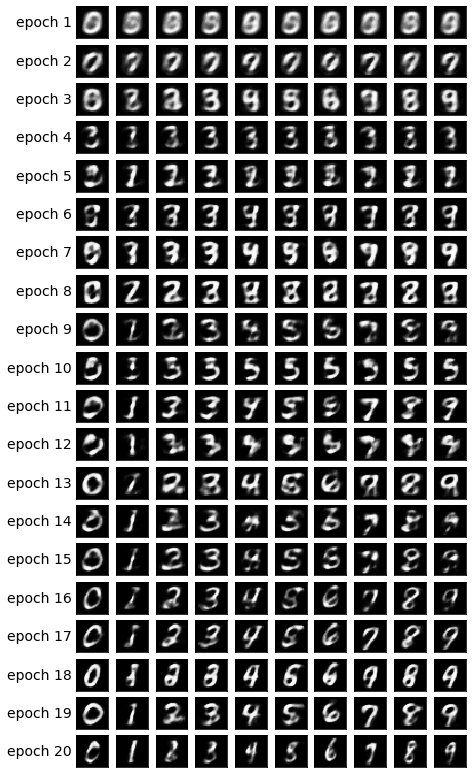

In [8]:
def plot_samples(samples):
    IMAGE_WIDTH = 0.7
    plt.figure(figsize=(IMAGE_WIDTH * num_digits,
                        len(samples) * IMAGE_WIDTH))
    for epoch, images in enumerate(samples):
        for digit, image in enumerate(images):
            plt.subplot(len(samples),
                        num_digits,
                        epoch * num_digits + digit + 1)
            plt.imshow(image.reshape((28, 28)),
                       cmap='Greys_r')
            plt.gca().xaxis.set_visible(False)
            if digit == 0:
                plt.gca().yaxis.set_ticks([])
                plt.ylabel('epoch {}'.format(epoch + 1),
                           verticalalignment='center',
                           horizontalalignment='right',
                           rotation=0,
                           fontsize=14)
            else:
                plt.gca().yaxis.set_visible(False)
                
                
plot_samples(samples)

**Commentaires**

C'est agréable de voir qu'en utilisant un simple réseau à action directe (pas de convolutions fantaisistes), nous sommes capables de générer de belles images après seulement 20 époques. Le modèle a appris à utiliser les dimensions spéciales des chiffres assez rapidement - à l'époque 9, nous voyons déjà la séquence de chiffres que nous essayions de générer.

Chaque époque a utilisé des valeurs aléatoires différentes pour les autres dimensions, nous pouvons donc voir comment le style diffère entre les époques, et est similaire à l'intérieur de chaque époque - au moins pour certaines époques. À l'époque 18 par exemple, tous les chiffres sont plus audacieux par rapport à l'époque 20.